## **Going Deeper 1. ResNet Ablation Study**

### Table of Contents

### 1. Introduction
* 1.1 What is Ablation Study?
* 1.2 What is Goal of Study?

### 2. Experiment Environment Set-up
* 2.1 Import Libraries

### 3. Data Load and Preprocessing
* 3.1 Data Load
* 3.2 Data Preprocessing

### 4. ResNet Modeling
* 4.1 Buliding Blocks
* 4.2 Complete Model

### 5. Model Training
* 5.1 ResNet-34
* 5.2 Plain-34
* 5.3 Plain-50

### 6. Visualization Loss and Accuracy
* 6.1 Loss
* 6.2 Accuracy

### 7. Result and Conclusion

### 8. Retrospection

***

### 1. Introduction

### 1.1 What is Ablation Study?

* **애블레이션 연구(Ablation Study)** : "아이디어를 제거해 봄"으로써 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험

**[ResNet에서 제시한 Residual Connection의 Ablation Study]**

* ImageNet의 validation dataset에 대한 Top-1 error rate을 지표로 사용
* residual connection이 없는 일반 네트워크(plain net)와 ResNet을 비교
* 이 비교를 통해 ResNet이 깊은 네트워크를 쌓았을 때, 성능 향상을 얻을 수 있음을 증명

<p align="center"><img src = 'https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-2_KU8V5aZ.max-800x600.png'></p>

### 1.2 What is Goal of Study?

**[프로젝트 목표]**

`cats_vs_dogs` 데이터셋에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교하여 ResNet(34, 50) 및 residual connection의 유효성을 확인하는 것

<p align="center"><img src = 'https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png'></p>

### 2. Experiment Environment Set-up

### 2.1 Import Libraries

In [2]:
import urllib3
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.utils import plot_model

### 3. Data Load and Preprocessing

* [cats_vs_dogs from Tensorflow dataset](https://www.tensorflow.org/datasets/catalog)

### 3.1 Data Load

In [12]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해본다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
urllib3.disable_warnings()

tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않는다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[20%:]', 'train[:20%]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)

In [14]:
# 데이터셋의 feature 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [15]:
# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


* Tensorflow의 데이터셋은 Numpy가 아니므로 ds_train.shape 같은 게 존재하지 않는다.
* 전체 데이터에서 80%를 `ds_train`, 20%를 `ds_test`로 분리했다.

In [16]:
# 클래스 개수 확인
ds_info.features["label"].num_classes

2

In [17]:
# 라벨의 이름 확인
ds_info.features["label"].names

['cat', 'dog']

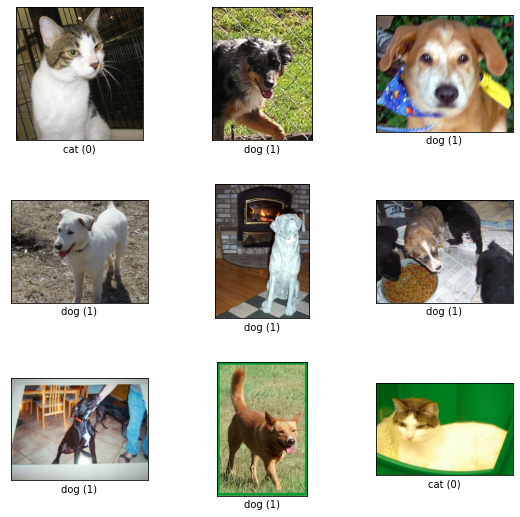

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

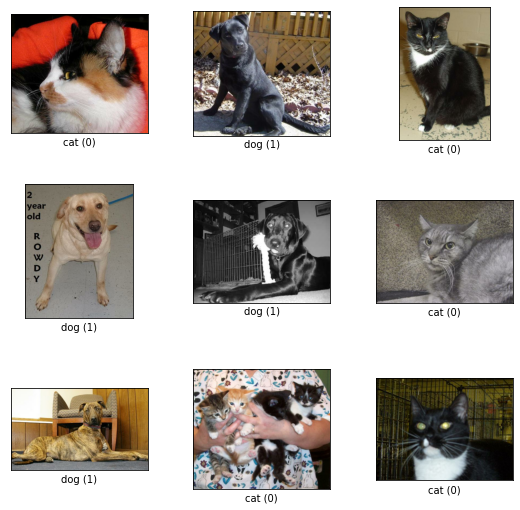

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

### 3.2 Data Preprocessing

In [20]:
# 각 채널별 최댓값인 255로 정규화(normalize)
# 이미지 크기가 제각각이므로 224, 224로 통일시킨다.

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [21]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

* 데이터 전처리 함수를 통해 모델 학습 전 전체 데이터를 preprocessing 할 수 있도록 한다.

### 4. ResNet Modeling

### 4.1 Building Blocks

**[ResNet 기본 블록 구성하기]**
* **ResNet-34**와 **ResNet-50** 네트워크를 직접 만들어본다.
* 반복문과 조건문을 사용하여 **ResNet-34**, **ResNet-50**, **Plain-34**, **Plain-50** 네트워크를 모두 생성할 수 있는 블록을 만들어본다.
* 우선 **ResNet-34**와 **ResNet-50**에서 사용되는 블록의 공통점과 차이점을 찾아본다.

**[공통점]**
* conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있다.

**[차이점]**
* ResNet-34와 ResNet-50의 블록 내부 구성
  * ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있
  * ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 된다.

[**[ResNet-50 주의사항]**](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006)
* conv3_1, conv4_1, conv5_1의 블록에서 `stride`=2로 정의
* conv2_x, conv3_x, conv4_x, conv5_x 사이의 shortcut connection은 `stride`=2로 정의


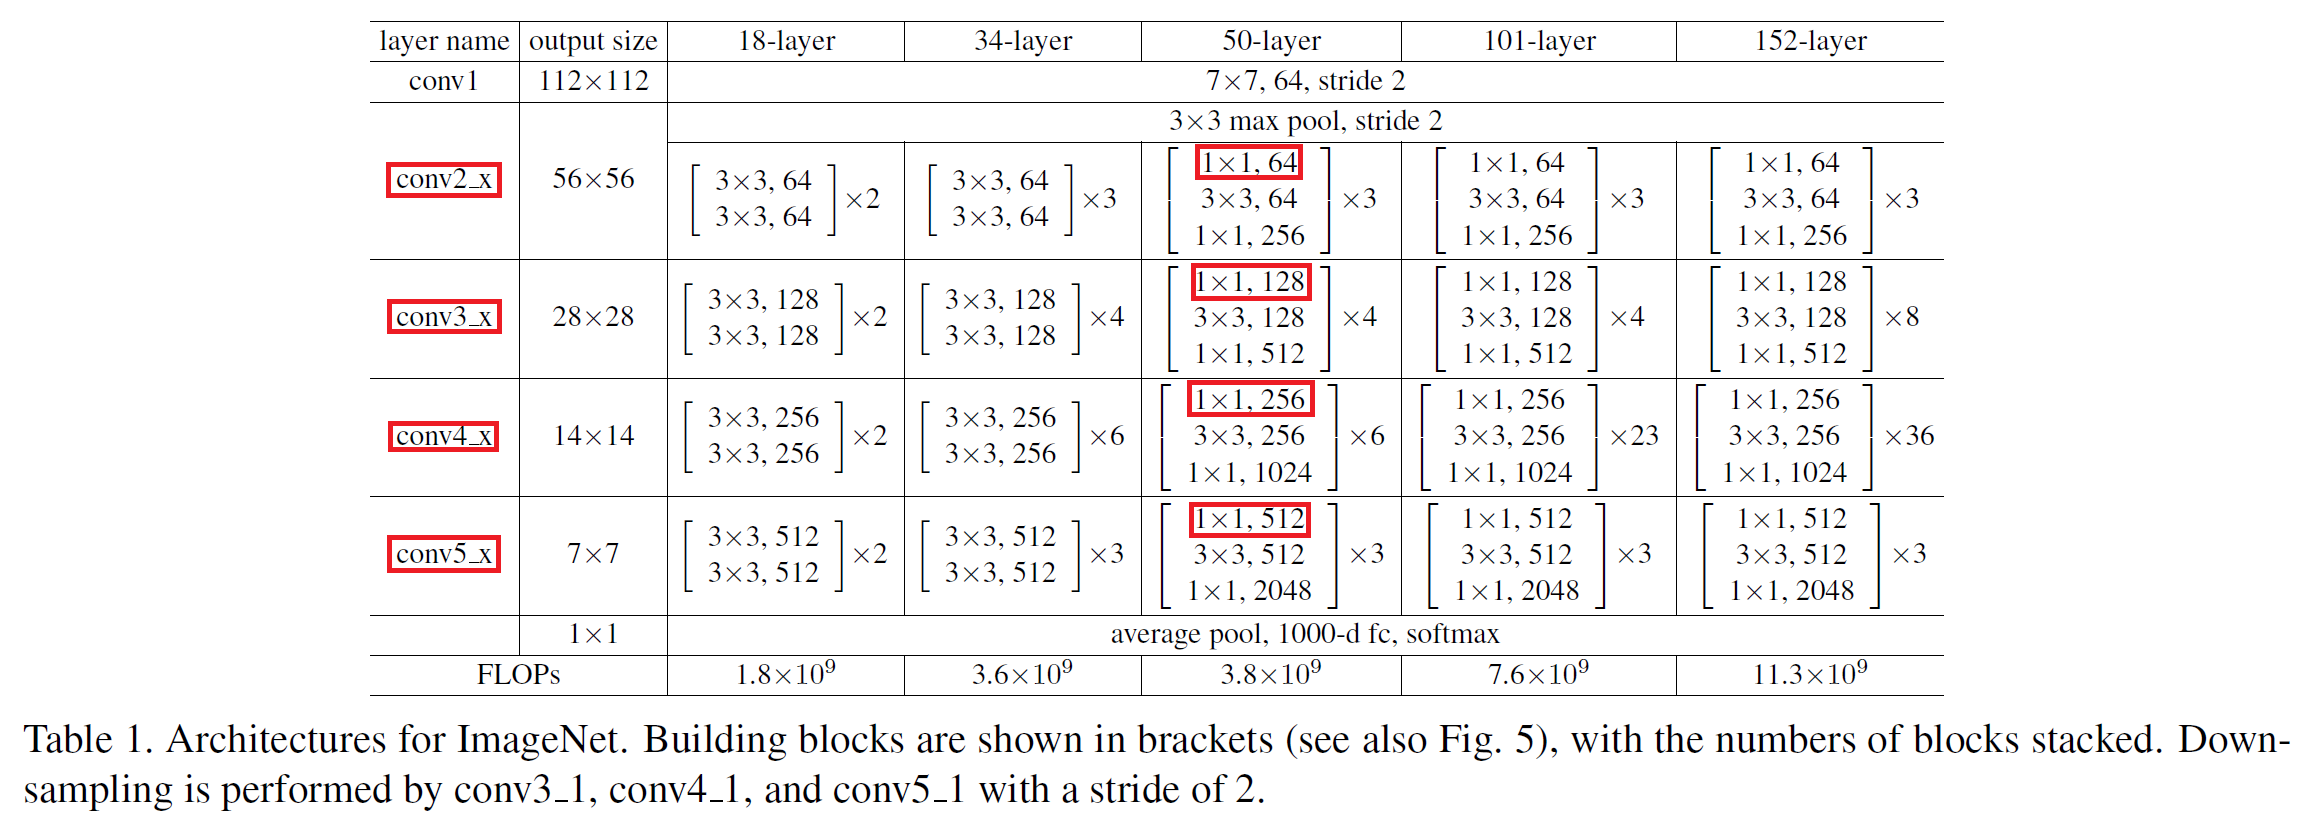

In [3]:
# is_50 : True → resnet_50
# is_plain :True → no shortcut connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False, is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                use_bias=False
            )(x)
            x = BatchNormalization()(x)
            x = Activation(activations.relu)(x)
            x = Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                use_bias=False
            )(x)
            x = BatchNormalization()(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = Conv2D(channel, kernel_size=(1,1), strides=(1,1), use_bias=False, padding="same")(identity)
                # shortcut connection
                x = Add()([x,identity])
                x = Activation(activations.relu)(x)   
            else:
                pass
    else :
        for cnn_num in range(num_cnn):
            # channel이 64인 경우
            if channel==64:
                identity = x
                x = Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)
                x = Activation(activations.relu)(x)
                x = Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)
                x = Activation(activations.relu)(x)
                x = Conv2D(
                    filters=channel * 4,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)

                if not is_plain:
                    if cnn_num==0:

                        identity_channel = identity.shape.as_list()[-1]

                        if identity_channel != channel:
                            identity = Conv2D(filters=channel*4, kernel_size=(1, 1), strides=2, use_bias=False, padding="valid")(identity)
                        # shortcut connection
                        x = Add()([x,identity])
                        x = Activation(activations.relu, axis = 3)(x)

                    else:
                        identity_channel = identity.shape.as_list()[-1]

                        if identity_channel != channel:
                            identity = Conv2D(filters=channel*4, kernel_size=(1, 1), strides=1, use_bias=False, padding="valid")(identity)
                        # shortcut connection
                        x = Add()([x,identity])
                        x = Activation(activations.relu, axis = 3)(x)      
                else:
                    pass

            # channel이 64가 아닌 경우
            else:
                identity = x
                if cnn_num==0:
                    x = Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        strides=(2,2),
                        kernel_initializer='he_normal',
                        padding='valid',
                        use_bias=False
                    )(x)
                else:
                    x = Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        strides=(1,1),
                        kernel_initializer='he_normal',
                        padding='valid',
                        use_bias=False
                    )(x)                    
                x = BatchNormalization()(x)
                x = Activation(activations.relu)(x)
                x = Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)
                x = Activation(activations.relu)(x)
                x = Conv2D(
                    filters=channel * 4,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    use_bias=False
                )(x)
                x = BatchNormalization()(x)

                if not is_plain:
                    if cnn_num==0:

                        identity_channel = identity.shape.as_list()[-1]

                        if identity_channel != channel:
                            identity = Conv2D(filters=channel*4, kernel_size=(1, 1), strides=2, use_bias=False, padding="valid")(identity)
                        # shortcut connection
                        x = Add()([x,identity])
                        x = Activation(activations.relu, axis = 3)(x)

                    else:
                        identity_channel = identity.shape.as_list()[-1]

                        if identity_channel != channel:
                            identity = Conv2D(filters=channel*4, kernel_size=(1, 1), strides=1, use_bias=False, padding="valid")(identity)
                        # shortcut connection
                        x = Add()([x,identity])
                        x = Activation(activations.relu, axis = 3)(x)      
                else:
                    pass

    return x

### 4.2 Complete Model

In [4]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10, is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = ZeroPadding2D(padding=(3, 3))(output)
    output = Conv2D(filters=64,
                       kernel_size = (7,7),
                       strides = (2,2)
                       )(output)
    output = BatchNormalization()(output)
    
    #conv2_x pooling
    output = MaxPooling2D(pool_size = (3,3),
                          strides = (2,2))(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            is_plain=is_plain
        )    
    output = AveragePooling2D(padding = 'same')(output)
    output = Flatten(name='flatten')(output)
    output = Dense(512, activation='relu', name='fc1')(output)    
    output = Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

### 4.2.1 ResNet-34

In [5]:
resnet_34 = build_resnet(input_shape=(224,224,3), is_50 = False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

### 4.2.2 ResNet-50

* ResNet-50 모델 생성을 위해 코드를 실행하면 `x = Add()([x,identity])`부분에서 에러 발생.
* 원인을 정확히 찾을 수가 없어 ResNet-50 모델은 따로 구현하였음.

### 4.2.3 Plain-34

In [7]:
plain_resnet_34 = build_resnet(input_shape=(224,224,3), is_50 = False, is_plain = True)
plain_resnet_34.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 230, 230, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_33 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                           

### 4.2.4 Plain-50

In [9]:
plain_resnet_50 = build_resnet(input_shape=(224,224,3), is_50 = True, is_plain = True)
plain_resnet_50.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 230, 230, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_66 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                           

### 5. Model Training

* `BATCH_SIZE`의 경우 논문과 동일하게 256으로 진행하고자 하였으나,
* GPU용량 문제로 에러가 발생해 논문보다 `BATCH_SIZE`를 낮춰서 진행하였음.

In [22]:
BATCH_SIZE = 32
EPOCH = 15

In [23]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### 5.1 ResNet-34

In [24]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 926s 2s/step - loss: 1.0049 - accuracy: 0.4989 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 2/15
581/581 [==============================] - 884s 2s/step - loss: 0.6996 - accuracy: 0.4977 - val_loss: 0.6993 - val_accuracy: 0.4948
Epoch 3/15
581/581 [==============================] - 883s 2s/step - loss: 0.6983 - accuracy: 0.5030 - val_loss: 0.7030 - val_accuracy: 0.4996
Epoch 4/15
581/581 [==============================] - 884s 2s/step - loss: 0.6982 - accuracy: 0.4966 - val_loss: 0.7021 - val_accuracy: 0.4970
Epoch 5/15
581/581 [==============================] - 884s 2s/step - loss: 0.6970 - accuracy: 0.5009 - val_loss: 0.6961 - val_accuracy: 0.4987
Epoch 6/15
581/581 [==============================] - 884s 2s/step - loss: 0.6965 - accuracy: 0.4974 - val_loss: 0.7229 - val_accuracy: 0.5000
Epoch 7/15
581/581 [==============================] - 884s 2s/step - loss: 0.6970 - accuracy: 0.4955 - val_loss: 0.6943 - val_accuracy: 0.4985

### 5.2 Plain-34

In [25]:
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 901s 2s/step - loss: 0.9496 - accuracy: 0.4978 - val_loss: 0.6975 - val_accuracy: 0.5024
Epoch 2/15
581/581 [==============================] - 858s 1s/step - loss: 0.6990 - accuracy: 0.4998 - val_loss: 0.6946 - val_accuracy: 0.5041
Epoch 3/15
581/581 [==============================] - 859s 1s/step - loss: 0.6987 - accuracy: 0.5027 - val_loss: 0.6952 - val_accuracy: 0.4994
Epoch 4/15
581/581 [==============================] - 857s 1s/step - loss: 0.7001 - accuracy: 0.4997 - val_loss: 0.7000 - val_accuracy: 0.4948
Epoch 5/15
581/581 [==============================] - 852s 1s/step - loss: 0.6989 - accuracy: 0.4980 - val_loss: 0.6943 - val_accuracy: 0.5043
Epoch 6/15
581/581 [==============================] - 852s 1s/step - loss: 0.6975 - accuracy: 0.4960 - val_loss: 0.6963 - val_accuracy: 0.4974
Epoch 7/15
581/581 [==============================] - 853s 1s/step - loss: 0.6965 - accuracy: 0.5002 - val_loss: 0.6937 - val_accuracy: 0.4968

### 5.3 Plain-50

In [26]:
plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
581/581 [==============================] - 167s 264ms/step - loss: 1.0427 - accuracy: 0.4965 - val_loss: 0.8976 - val_accuracy: 0.5355
Epoch 2/15
581/581 [==============================] - 149s 257ms/step - loss: 0.7259 - accuracy: 0.4929 - val_loss: 0.6948 - val_accuracy: 0.4946
Epoch 3/15
581/581 [==============================] - 148s 254ms/step - loss: 0.6993 - accuracy: 0.5005 - val_loss: 0.7180 - val_accuracy: 0.4983
Epoch 4/15
581/581 [==============================] - 148s 254ms/step - loss: 0.6980 - accuracy: 0.4994 - val_loss: 0.6938 - val_accuracy: 0.5181
Epoch 5/15
581/581 [==============================] - 148s 254ms/step - loss: 0.6976 - accuracy: 0.4973 - val_loss: 0.6939 - val_accuracy: 0.4994
Epoch 6/15
581/581 [==============================] - 148s 255ms/step - loss: 0.6977 - accuracy: 0.4992 - val_loss: 0.7004 - val_accuracy: 0.4957
Epoch 7/15
581/581 [==============================] - 148s 255ms/step - loss: 0.6979 - accuracy: 0.5009 - val_loss: 0.6938 -

### 6. Visualization Loss and Accuracy

* ResNet-50의 결과는 `history`에 저장되어있는 리스트를 가져왔다.
* `Attachment,ResNet-50.ipynb` 참조

In [1]:
history_resnet_50 = {'loss': [0.9199658632278442,
  0.6989937424659729,
  0.6979464292526245,
  0.6971418857574463,
  0.699307382106781,
  0.6992338299751282,
  0.6973613500595093,
  0.6971814632415771,
  0.6974321007728577,
  0.6970767378807068,
  0.6959982514381409,
  0.6981124877929688,
  0.6967800259590149,
  0.6966327428817749,
  0.6959354281425476],
 'accuracy': [0.49720311164855957,
  0.49870815873146057,
  0.5003770589828491,
  0.5064054131507874,
  0.4975777864456177,
  0.4905802607536316,
  0.5033347606658936,
  0.4966602027416229,
  0.500968873500824,
  0.5033372640609741,
  0.5005382895469666,
  0.5007535815238953,
  0.4983326196670532,
  0.49714499711990356,
  0.5074763298034668],
 'val_loss': [0.6968756318092346,
  0.6950346827507019,
  0.7036826610565186,
  0.6954041123390198,
  0.6942451000213623,
  0.6986580491065979,
  0.6978269815444946,
  0.6986823081970215,
  0.6953768730163574,
  0.6936815977096558,
  0.6934104561805725,
  0.6956963539123535,
  0.693341851234436,
  0.6933925151824951,
  0.703016996383667],
 'val_accuracy': [0.5071428418159485,
  0.5034782886505127,
  0.5002164244651794,
  0.501724123954773,
  0.5,
  0.49112555384635925,
  0.4886956512928009,
  0.4882608652114868,
  0.5023707151412964,
  0.5015151500701904,
  0.5,
  0.49978262186050415,
  0.5056276917457581,
  0.49891775846481323,
  0.4906926453113556]}

### 6.1 Loss

In [2]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50['loss'], 'k')
plt.plot(history_plain_34.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='upper left')
plt.show()

NameError: ignored

* 잘못 클릭해서 출력된 결과물이 사라졌다.😥

### 6.2 Accuracy

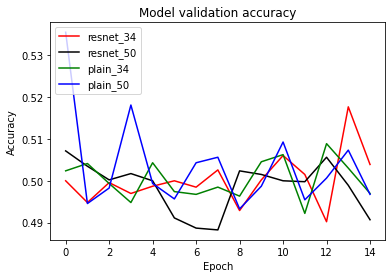

In [29]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50['val_accuracy'], 'k')
plt.plot(history_plain_34.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='upper left')
plt.show()

### 7. Result and Conclusion

* Loss에 대한 결과가 사라진 관계로 정확도 그래프만 보고서 판단해본다.
* 다만, 학습 시 출력된 Loss를 보면 학습이 진행됨에 따라 초반에 낮아지다 일정 epoch 이후 일정해지는 양상을 띄고 있는 것을 확인할 수 있다. 
* 정확도가 대부분 0.49 ~ 0.52 사이를 왔다갔다하고 있으며,
* 정확도만 두고 판단했을 때 네 개의 모델에서 큰 차이를 확인할 수 없었다.  
* Loss가 계속해서 줄어들지 못하고 accuracy에서도 모델 별 큰 차이를 확인 할 수 없는 것으로 보아 매개변수의 수정이 필요할 것으로 보인다.
* 위 학습 시 설정한 매개변수는 논문 상의 값으로 진행되었다.
* 논문은 cifar-10 데이터셋으로 학습이 진행된 것이기 때문에 차이가 있을 것으로 보인다.

### 8. Retrospection

### 8.1 What was difficult

* 모델 구현이 어려웠다.
* 생각보다 ResNet-34와 ResNet-50 사이의 차이가 많아 코드를 짜는 것이 어려웠다.
* 학습 시간이 너무 길어 다양한 시도를 해보지 못한게 아쉽다.

### 8.2 What I found out

* ResNet-34와 ResNet-50의 차이(Building Block의 **[ResNet-50 주의사항]** 참조)


### 8.3 What I want to know more about

* top-3, top-5 error를 확인할 수 있었으면 더 좋았을 것 같다.
```python
import tensorflow as tf
model.compile(optimizer, loss, metrics= [tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
```
* 모델 구현 시 에러가 났던 부분에 대해 더 살펴봐야 할 것 같다. (ResNet-50 부분)

### 8.4 Self-Resolution

* 머릿 속으로는 구상은 되지만, 코드로 구현하는 것은 또 별개의 문제인 것 같다.

**[Reference]**
* https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691
* https://github.com/KaimingHe/deep-residual-networks
* https://hwanny-yy.tistory.com/12
* https://tobigs.gitbook.io/tobigs/deep-learning/computer-vision/resnet-deep-residual-learning-for-image-recognition
* https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/ResNet18_CIFAR10_Train.ipynb
* https://stackoverflow.com/questions/42327006/how-to-calculate-top5-accuracy-in-keras

**[Attachment]**
* Attachment.ResNet-50.ipynb